# Is the car Damaged ? Creating a model from your own data



### Install the libraries

In [1]:
!pip install -Uqq fastai
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00


**The below are the steps we'll perform :**

---
1. Use DuckDuckGo to search for images of "car photos"
2. Use DuckDuckGo to search for images of "damaged car photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of a normal or damaged car and see if it works.

## STEP 1: Download the images of Normal and Damaged cars

In [23]:
from fastbook import *
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]


##Let's start by searching a "damaged car photo" and seeing what kind of result we get. We will start getting the urls.

In [22]:
urls = search_images_ddg('photo of a damaged car', max_images=1)
urls[0]

'http://qldcarremoval.com.au/wp-content/uploads/2017/06/qldcarremoval-cashfordamagedcars.jpg'

 ... and then you download a URL and take a look into it.

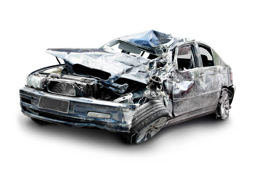

In [4]:
from fastdownload import download_url
dest = 'damaged-car.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

## Now let's try to get some "photos of a car".

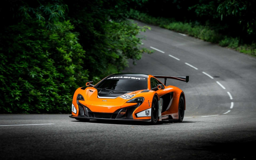

In [5]:
urls = search_images_ddg('photo of a car', max_images=1)
urls[0]

dest = 'car.jpg'
download_url(urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

## Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "photo of a car" and "photo of a damaged car" photos, and save each group of photos to a different folder:


In [6]:
searches = 'photo of a damaged car','photo of a car'
path = Path('car_damage')

if not path.exists():
  for o in searches:
      dest = (path/o)
      dest.mkdir(exist_ok=True, parents=True)
      download_images(dest, urls=search_images_ddg(f'{o} photo'))
      resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
print(path)

car_damage


### Remove the images that did not download correctly that can cause our model to fail.

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

## Step 2: Train our Model to understand the features of the Damaged cars and Cars

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


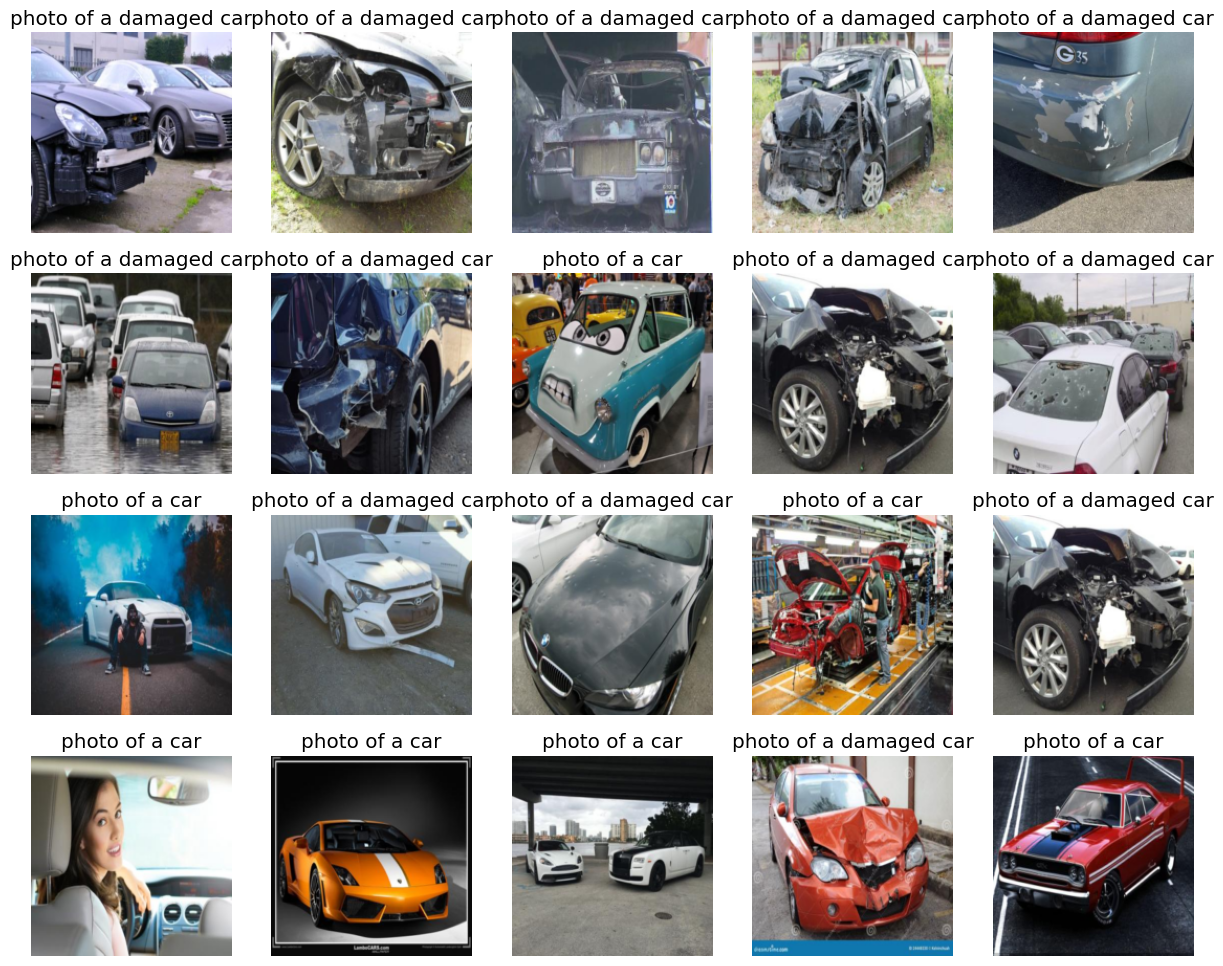

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=27),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)


dls.show_batch(max_n=20)

## Now we have got 200 images of Damaged cars and 200 images of Car and are able to label them properly. Displaying just 20 images to verify that laelling is done correctly on which model can be trained.

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "normal car" or "damaged car").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *photo of a car* or *photo of a damaged car*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

## Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

Let's look at more of our downloaded photos



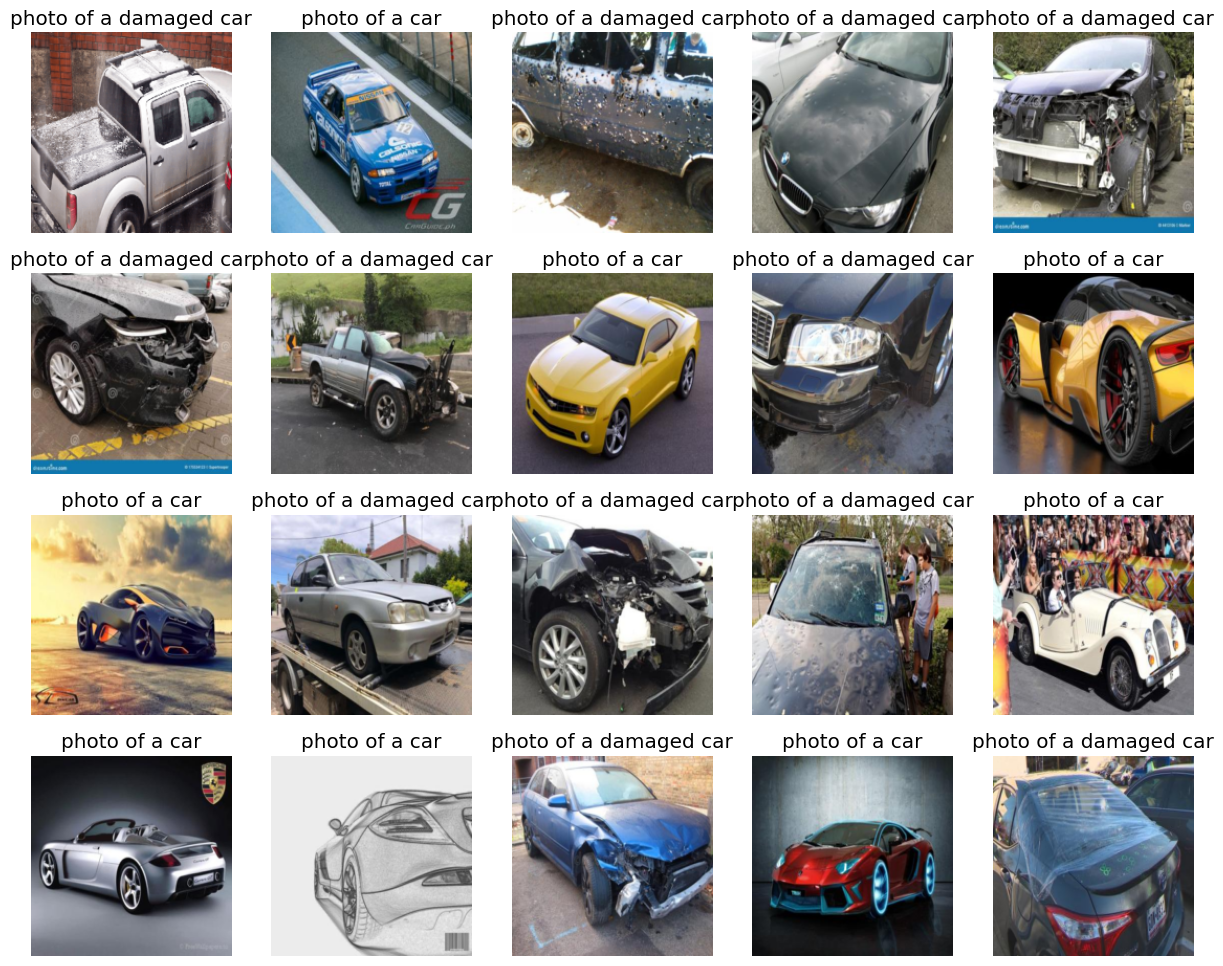

In [10]:
dls.show_batch(max_n=20)

##Step 3: Finetuning the resnet18 model according to my dataset by going through 30 iterations. We will keep a close watch on the error_rate to see the efficiency of the model.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(30)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


## Step 4: Let's see what our "fine tuned" model thinks about the new Unseen images that we downloaded earlier, and if it is able to Classify it successfully...

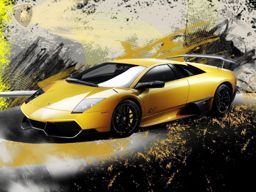

In [24]:
download_url(search_images('photo of a car', max_images=1)[0], 'car.jpg', show_progress=False)
Image.open('car.jpg').to_thumb(256,256)

In [25]:
is_damaged_car,_,probs = learn.predict(PILImage.create('car.jpg'))
print(f"This is a: {is_damaged_car}. ")
print(f"Probability it's a car: {probs[0]:.4f}")

This is a: photo of a car. 
Probability it's a car: 1.0000


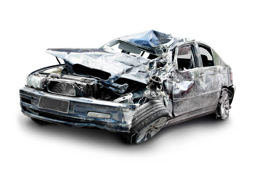

In [27]:
download_url(search_images('photo of a damaged car', max_images=1)[0], 'damaged-car.jpg', show_progress=False)
Image.open('damaged-car.jpg').to_thumb(256,256)

In [30]:
is_damaged_car,_,probs = learn.predict(PILImage.create('damaged-car.jpg'))
print(f"This is a: {is_damaged_car}. ")
print(f"Probability it's a car: {probs[0]:.4f}")

This is a: photo of a damaged car. 
Probability it's a car: 0.0105


In [ ]:
# @title
## Conclusion: The model is able to classify the "Damaged car" from "Regular Car".